# **Sentiment Analysis for Investment Strategies on Tesla Stock**

# 4. Sentiment Analysis of News and Impact on Tesla Stock
Data in the past 30 days (from **2023-9-12** to **2023-10-11**) has been collected and cleaned up a little in the previous step from APIs.

From the previous step, we generate a label from Flan-T5 with ICL (one-shot prompt engineering) to classify if a news is directly related to Tesla or not.

A pre-trained transformer model is utilized to perform sentiment analysis on all news related to Tesla.
* [FinBERT](https://huggingface.co/ProsusAI/finbert): developed for financial sentiment analysis with BERT
* The model provides two outputs: label and confidence score. Labels are positive, negative and neutral. Confidence socres vary from 0 to 1.

After sentiment analysis, correlation between the news sentiments and Tesla stock is investigated for potential short-term (days or weeks) investment strategies.

## 4.1. Import Libarires

In [1]:
import torch
torch.__version__

'1.12.1'

In [78]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix, classification_report

## 4.2. Create Sentiment Analysis Pipeline

### 4.2.1. Load Pre-trained Model

In [3]:
# choose finbert model which is a pre-trained LL model to analyze sentiment of financial text
model_name = "ProsusAI/finbert"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

**Note:** It requires some time to load the model if loading for the first time.

### 4.2.2. Define a Pipeline for Sentiment Analysis

In [4]:
# create a pipeline for sentiment analysis
sent_ana = pipeline(task = 'sentiment-analysis', model = model, tokenizer = tokenizer)

In [5]:
# play with the encode and decode
tokens = tokenizer.encode('Tesla just launched its first self-driving car!', return_tensors = 'pt')
tokens

tensor([[  101, 26060,  2074,  3390,  2049,  2034,  2969,  1011,  4439,  2482,
           999,   102]])

In [6]:
tokenizer.decode(tokens[0])

'[CLS] tesla just launched its first self - driving car! [SEP]'

In [7]:
# test 1
text = 'Tesla just launched its first self-driving car!'

result = sent_ana(text)
result

[{'label': 'neutral', 'score': 0.8160327672958374}]

In [8]:
# test 2
text = 'Tesla just successfully launched its first self-driving car!'

result = sent_ana(text)
result

[{'label': 'positive', 'score': 0.5273283123970032}]

In [9]:
# test 3
text = 'Tesla failed to launch its first self-driving car!'

result = sent_ana(text)
result

[{'label': 'negative', 'score': 0.5945389270782471}]

**Note:** The loaded model works as epxected.

## 4.3. Sentiment Analysis on News
### 4.3.1. Input Data
<span style='color: blue'>**345 news articles were generated for this sentiment analysis after the following steps:**<span>
* extracted from NewsAPI in the past 30 days
* filter by key word 'Tesla' or 'Elon Musk' in title or content
* drop duplicates having identical source and title

<span style='color: blue'>**In order to evaluate the performance of FinBERT model on Tesla news sentiment analysis, I manually labeled 207 news (60% of total) for sentiments and whether they are Tesla related or not.**</span>
    
From manuual labeling:
* About half of the news are directly related to Tesla.
* The other half of the news are basically about Elon Musk, his personalities, his personal life dramma, his views on sensetice political issues and religious conflicts, and news on his other companies. I labeled all those as not related to Tesla assuming minimum impact of them on Tesla stock prices.
* I don't have any financial background. These labels may not be representitive of public opinion.

<span style='color: blue'>**In the previous step, a label was created using Flan-T5 model with one-shot learning to classify if a news article was related to Tesla or not for all 345 news articles.**</span>

In [21]:
# load news with labels
df_news = pd.read_csv('../data/News_Classification_One_Class.csv')
df_news.head()

,source_name,author,date,title,description,content,title_desc,one_shot_class,tesla_related,label
0,Fortune,Jane Thier,2023-09-12,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,How Elon Musk lost a friend over AI: Google co...,yes,yes,neutral
1,CNN,Paul Glader,2023-09-12,Four takeaways from Walter Isaacson's biograph...,"""You'll never be successful,"" Errol Musk in 19...","Youll never be successful, Errol Musk in 1989 ...",Four takeaways from Walter Isaacson's biograph...,no,NaN,NaN
2,Business Insider,Grace Dean,2023-09-12,After Elon Musk spoke to Neuralink director Sh...,Zilis said that choosing to have Musk as a spe...,nullChesnot/Getty Images\n<ul><li>Elon Musk an...,After Elon Musk spoke to Neuralink director Sh...,no,NaN,NaN
3,Financial Post,Bloomberg News,2023-09-12,Tesla gets $80-billion boost from analyst call...,Some investors find Tesla Inc.'s $500-billion ...,Some investors find the $500-billion projectio...,Tesla gets $80-billion boost from analyst call...,yes,NaN,NaN
4,CNN,"Catherine Thorbecke, CNN",2023-09-12,Tesla shares jump after Morgan Stanley predict...,Teslas Dojo supercomputer could fuel a $500 b...,Teslas Dojo supercomputer could fuel a $500 bi...,Tesla shares jump after Morgan Stanley predict...,yes,NaN,NaN


In [22]:
# check for missing data
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   source_name     345 non-null    object
 1   author          342 non-null    object
 2   date            345 non-null    object
 3   title           345 non-null    object
 4   description     345 non-null    object
 5   content         345 non-null    object
 6   title_desc      345 non-null    object
 7   one_shot_class  345 non-null    object
 8   tesla_related   207 non-null    object
 9   label           207 non-null    object
dtypes: object(10)
memory usage: 27.1+ KB


**Note:** The summary above confirmed that there were 207 manual labels.

In [23]:
# check if there is any error in the manual label
df_news['one_shot_class'].value_counts()

yes    186
no     159
Name: one_shot_class, dtype: int64

**Note:** More than half of the news were related to Tesla.

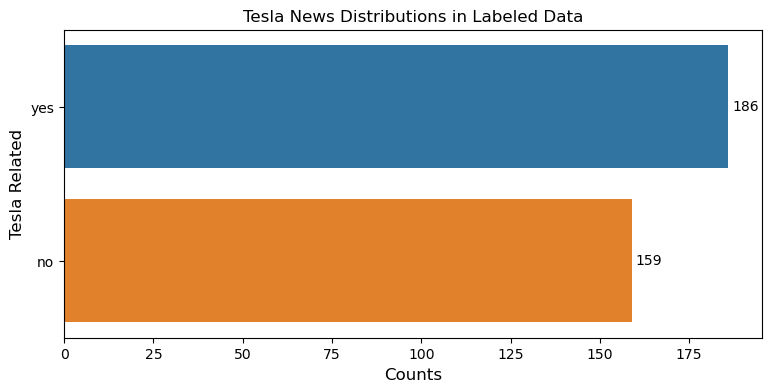

In [24]:
# plot the distribution
plt.figure(figsize = (9, 4))

ax = sns.countplot(data = df_news, y = 'one_shot_class')
# add numbers
for patch in ax.patches:
    width = patch.get_width()
    ax.text(
        width+1,
        patch.get_y()+patch.get_height()/2,
        format(width, '1.0f'),
        va = 'center'
    )

plt.title('Tesla News Distributions in Labeled Data')
plt.xlabel('Counts', fontsize = 12)
plt.ylabel('Tesla Related', fontsize = 12)
plt.show()

In [25]:
# next look at the manual sentiment label
df_news['label'].value_counts()

neutral     84
negative    64
positive    59
Name: label, dtype: int64

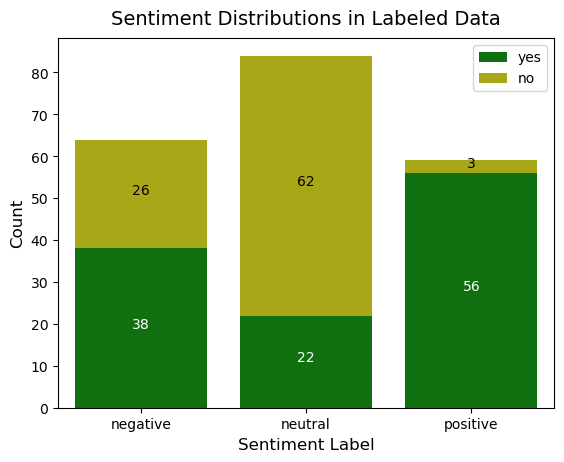

In [26]:
# plot the news sentiment distribution
counts = pd.crosstab(df_news['label'], df_news['tesla_related'])

fig, ax = plt.subplots()

sns.barplot(x = counts.index, y = counts['yes'], color = 'g', label = 'yes', ax = ax)
sns.barplot(x = counts.index, y = counts['no'], bottom = counts['yes'], color = 'y', label = 'no', ax = ax)

i = 0
for patch in ax.patches:
    height = patch.get_height()   
    if i < 3:
        ax.text(
            patch.get_x() + patch.get_width()/2,
            height / 2.0,
            format(height, '1.0f'),
            color = 'white',
            ha = 'center'
        )
    else:
        ax.text(
            patch.get_x() + patch.get_width()/2,
            height/2 + counts['yes'][i-3],
            format(height, '1.0f'),
            ha = 'center'
        )
    i += 1

plt.legend()    
plt.title('Sentiment Distributions in Labeled Data', fontsize = 14, pad = 10)
plt.xlabel('Sentiment Label', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
    
plt.show()

**Note:** 
* 40% news were labeled as neutral.
* Negative news and positive ones are comparable.
* For news directly related to Tesla, there are more positive news than negative news.
* For news not related to Tesla, majority is neutral in the manual labels.

### 4.3.2. Sentiment Anlsysi with FinBERT

There are 3 text features for each news, `title`, `content` and `description`.

The manual labeling was perfomed mainly based on 'title' + 'description', `title_desc`.

In [27]:
df_news.head(2)

,source_name,author,date,title,description,content,title_desc,one_shot_class,tesla_related,label
0,Fortune,Jane Thier,2023-09-12,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,How Elon Musk lost a friend over AI: Google co...,yes,yes,neutral
1,CNN,Paul Glader,2023-09-12,Four takeaways from Walter Isaacson's biograph...,"""You'll never be successful,"" Errol Musk in 19...","Youll never be successful, Errol Musk in 1989 ...",Four takeaways from Walter Isaacson's biograph...,no,NaN,NaN


In [28]:
# define a function for sentiment analysis
def sentiment_results(df, target_cols):
    for item in target_cols:
        new_label = item + '_label'
        new_score = item + '_score'
        # perform sentiment analysis for each entry and store the label and the score
        for i in range(df.shape[0]):
            try:
                result = sent_ana(df.loc[i, item])
                df.loc[i, new_label] = result[0]['label']
                df.loc[i, new_score] = result[0]['score']
            except:
                print('The {}th row in {} column raised error.'.format(i, item))
    return df

In [29]:
# get sentiment analysis results for title first
starttime = time.time()

target_cols = ['title', 'content', 'description', 'title_desc']
df_news_sa = sentiment_results(df_news, target_cols)

endtime = time.time()

In [30]:
print('Runtime: {:.2f} minutes'.format((endtime-starttime)/60))

Runtime: 99.89 minutes


In [31]:
df_news_sa.head()

,source_name,author,date,title,description,content,title_desc,one_shot_class,tesla_related,label,title_label,title_score,content_label,content_score,description_label,description_score,title_desc_label,title_desc_score
0,Fortune,Jane Thier,2023-09-12,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,How Elon Musk lost a friend over AI: Google co...,yes,yes,neutral,negative,0.763145,neutral,0.658006,neutral,0.500911,negative,0.581649
1,CNN,Paul Glader,2023-09-12,Four takeaways from Walter Isaacson's biograph...,"""You'll never be successful,"" Errol Musk in 19...","Youll never be successful, Errol Musk in 1989 ...",Four takeaways from Walter Isaacson's biograph...,no,NaN,NaN,neutral,0.925487,neutral,0.894971,neutral,0.647073,neutral,0.852819
2,Business Insider,Grace Dean,2023-09-12,After Elon Musk spoke to Neuralink director Sh...,Zilis said that choosing to have Musk as a spe...,nullChesnot/Getty Images\n<ul><li>Elon Musk an...,After Elon Musk spoke to Neuralink director Sh...,no,NaN,NaN,neutral,0.914428,neutral,0.813839,neutral,0.793502,neutral,0.875956
3,Financial Post,Bloomberg News,2023-09-12,Tesla gets $80-billion boost from analyst call...,Some investors find Tesla Inc.'s $500-billion ...,Some investors find the $500-billion projectio...,Tesla gets $80-billion boost from analyst call...,yes,NaN,NaN,positive,0.771905,negative,0.794208,neutral,0.501461,neutral,0.567451
4,CNN,"Catherine Thorbecke, CNN",2023-09-12,Tesla shares jump after Morgan Stanley predict...,Teslas Dojo supercomputer could fuel a $500 b...,Teslas Dojo supercomputer could fuel a $500 bi...,Tesla shares jump after Morgan Stanley predict...,yes,NaN,NaN,positive,0.648511,positive,0.940959,positive,0.928625,positive,0.907800


In [32]:
# check for missing data
df_news_sa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source_name        345 non-null    object 
 1   author             342 non-null    object 
 2   date               345 non-null    object 
 3   title              345 non-null    object 
 4   description        345 non-null    object 
 5   content            345 non-null    object 
 6   title_desc         345 non-null    object 
 7   one_shot_class     345 non-null    object 
 8   tesla_related      207 non-null    object 
 9   label              207 non-null    object 
 10  title_label        345 non-null    object 
 11  title_score        345 non-null    float64
 12  content_label      345 non-null    object 
 13  content_score      345 non-null    float64
 14  description_label  345 non-null    object 
 15  description_score  345 non-null    float64
 16  title_desc_label   345 non

In [33]:
# since the sentiment analysis takes quite some time to run, better to save out the raw sentiment analysis outputs
df_news_sa.to_csv('../data/News_Sentiments_FinBERT.csv', index = False)

In [36]:
# load in sentiment analysis results
df_sa = pd.read_csv('../data/News_Sentiments_FinBERT.csv')
df_sa.head(2)

,source_name,author,date,title,description,content,title_desc,one_shot_class,tesla_related,label,title_label,title_score,content_label,content_score,description_label,description_score,title_desc_label,title_desc_score
0,Fortune,Jane Thier,2023-09-12,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,How Elon Musk lost a friend over AI: Google co...,yes,yes,neutral,negative,0.763145,neutral,0.658006,neutral,0.500911,negative,0.581649
1,CNN,Paul Glader,2023-09-12,Four takeaways from Walter Isaacson's biograph...,"""You'll never be successful,"" Errol Musk in 19...","Youll never be successful, Errol Musk in 1989 ...",Four takeaways from Walter Isaacson's biograph...,no,NaN,NaN,neutral,0.925487,neutral,0.894971,neutral,0.647073,neutral,0.852819


In [37]:
# check the loaded dataframe for consistency
df_sa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source_name        345 non-null    object 
 1   author             342 non-null    object 
 2   date               345 non-null    object 
 3   title              345 non-null    object 
 4   description        345 non-null    object 
 5   content            345 non-null    object 
 6   title_desc         345 non-null    object 
 7   one_shot_class     345 non-null    object 
 8   tesla_related      207 non-null    object 
 9   label              207 non-null    object 
 10  title_label        345 non-null    object 
 11  title_score        345 non-null    float64
 12  content_label      345 non-null    object 
 13  content_score      345 non-null    float64
 14  description_label  345 non-null    object 
 15  description_score  345 non-null    float64
 16  title_desc_label   345 non

## 4.4. FinBERT Sentiment Analysis Performance Evaluation

Sentiment labels from FinBERT model for the same article can be different when using different features for analysis.

There are also confidence scores together with the sentiment results. Therefore, the following will be evaluated to find the best match to mannual labels:
* from `title`
* from `description`
* from `content`
* from `title_desc`
* the one with highest score

Since there are news not directly related to Tesla, separate evaluations are performed for all news and those only directly related to Tesla.

**Confusion matrix** together with **classification report** are used for the model performance evaluation.

In [38]:
# for this evaluation, need to extract data with manual labels
df_val = df_sa[~df_sa['label'].isnull()]
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207 entries, 0 to 343
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source_name        207 non-null    object 
 1   author             207 non-null    object 
 2   date               207 non-null    object 
 3   title              207 non-null    object 
 4   description        207 non-null    object 
 5   content            207 non-null    object 
 6   title_desc         207 non-null    object 
 7   one_shot_class     207 non-null    object 
 8   tesla_related      207 non-null    object 
 9   label              207 non-null    object 
 10  title_label        207 non-null    object 
 11  title_score        207 non-null    float64
 12  content_label      207 non-null    object 
 13  content_score      207 non-null    float64
 14  description_label  207 non-null    object 
 15  description_score  207 non-null    float64
 16  title_desc_label   207 non

### 4.4.1. Get the highest-score label

In [40]:
# create a function to get the label with the highest score for each row in the dataframe
def get_high_score_label(row):
    labels = ['title_label', 'content_label', 'description_label', 'title_desc_label']
    scores = [row['title_score'], row['content_score'], row['description_score'], row['title_desc_score']]
    i_high = scores.index(max(scores))
    return row[labels[i_high]]

In [50]:
# create a news high_score_label
df_val['label_high_score'] = df_val.apply(get_high_score_label, axis = 1)
df_val.head(2)

C:\Users\wfei2\AppData\Local\Temp\ipykernel_12000\1361453271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['label_high_score'] = df_val.apply(get_high_score_label, axis = 1)


,source_name,author,date,title,description,content,title_desc,one_shot_class,tesla_related,label,title_label,title_score,content_label,content_score,description_label,description_score,title_desc_label,title_desc_score,label_high_score
0,Fortune,Jane Thier,2023-09-12,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,How Elon Musk lost a friend over AI: Google co...,yes,yes,neutral,negative,0.763145,neutral,0.658006,neutral,0.500911,negative,0.581649,negative
8,Fox News,"Brian Flood, Nikolas Lanum",2023-09-12,Elon Musk biography contains inaccurate tale o...,Author Walter Isaacson admitted he made a mist...,"Author Walter Isaacson acknowledged a ""mistake...",Elon Musk biography contains inaccurate tale o...,no,no,neutral,negative,0.739858,negative,0.628192,negative,0.773437,negative,0.606766,negative


### 4.4.2. Compared with manual labels

In [43]:
# define a function to convert text label to numbers for confusion matrix plotting
def text2num(x):
    if x == 'positive':
        return 2
    elif x == 'neutral':
        return 1
    elif x == 'negative':
        return 0

In [44]:
# define a function to plot confusion matrix
def cmplot(data, col):
    
    cm_title = confusion_matrix(data['label'].apply(text2num), data[col].apply(text2num))

    labels = ['negative', 'neutral', 'positive']
    sns.heatmap(cm_title, annot = True, xticklabels = labels, yticklabels = labels)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion matrix for sentiment labels from {}'.format(col), pad = 10)

    plt.show()

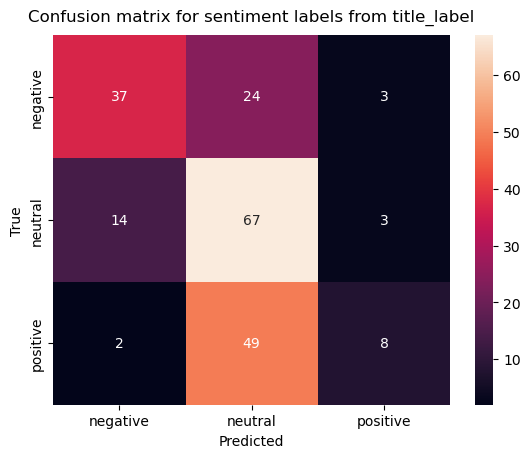

In [45]:
# plot cm for title label
cmplot(df_val, 'title_label')

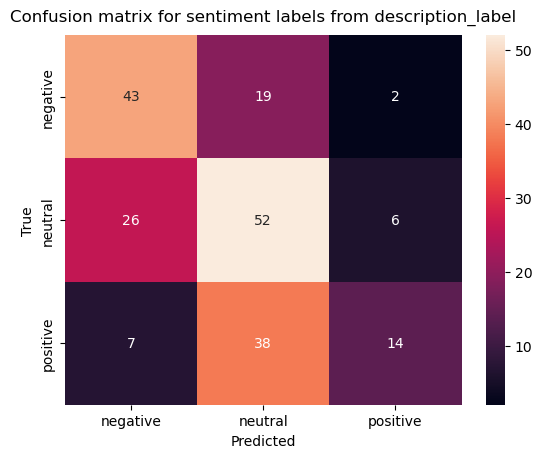

In [46]:
# plot cm for description label
cmplot(df_val, 'description_label')

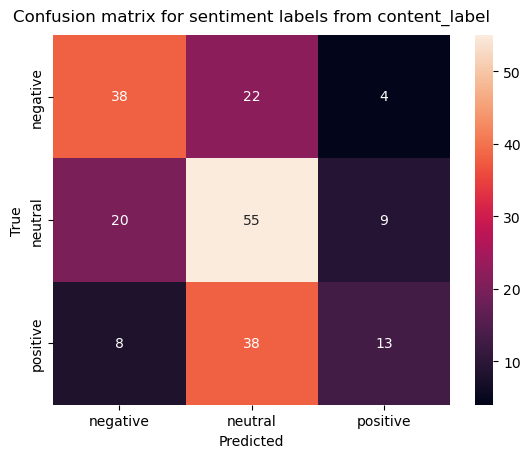

In [47]:
# plot cm for content label
cmplot(df_val, 'content_label')

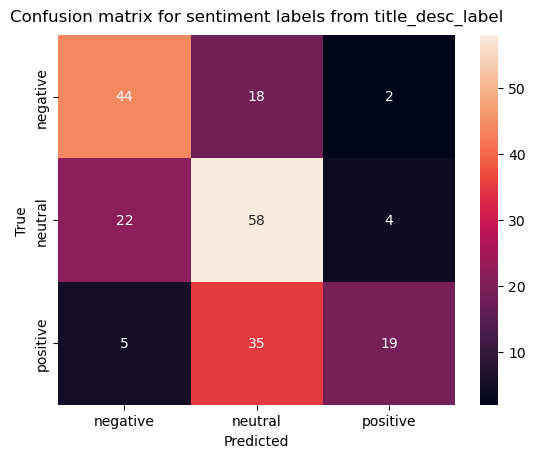

In [48]:
# plot cm for title + description label
cmplot(df_val, 'title_desc_label')

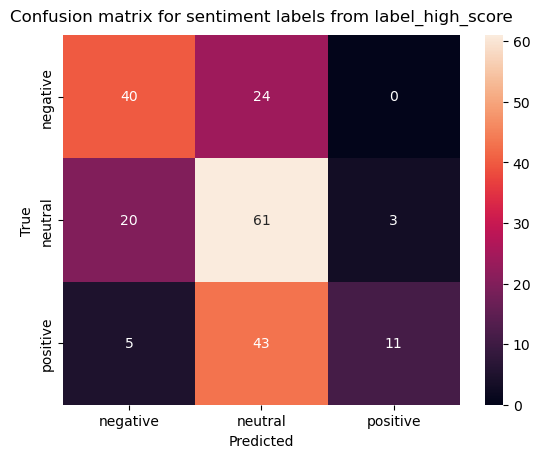

In [51]:
# plot cm for best score label
cmplot(df_val, 'label_high_score')

**Note:** 
* Performance from different labels are not significantly different from each other for all news.
* If only looking at positive and negative cases, predictions from title_description matches with manual labels best as expected.
* FinBert model tends to mark more news as neutral compared to manual labels.

### 4.4.3. For news related to Tesla

In [52]:
# extract data related to tesla
df_val_tesla = df_val[df_val['tesla_related'] == 'yes']
df_val_tesla['tesla_related'].value_counts()

yes    116
Name: tesla_related, dtype: int64

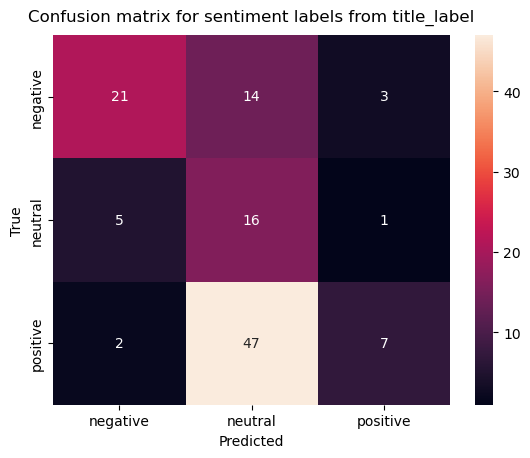

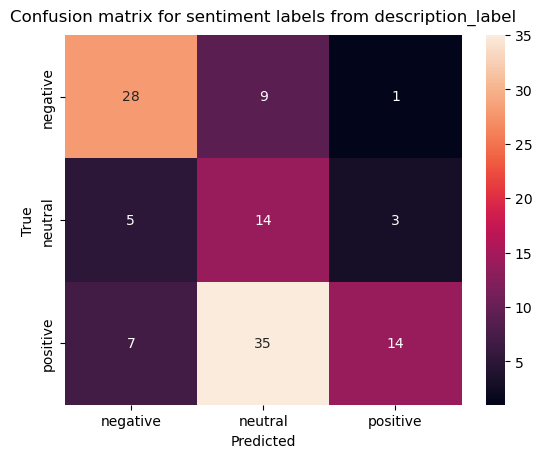

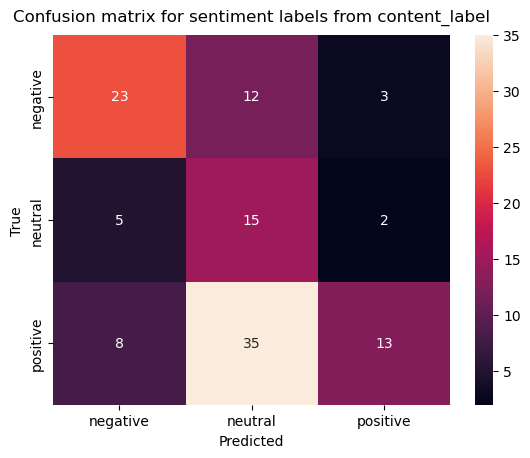

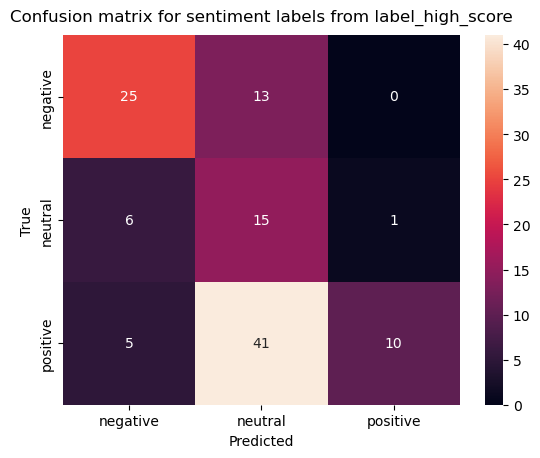

In [53]:
# plot confusion matrix
cols = ['title_label', 'description_label', 'content_label', 'label_high_score']
for col in cols: 
    cmplot(df_val_tesla, col)

**Note:**
* **Sentments from `description` matches the best with the manual labels.**
* **FinBERT model tends to label positive news as neutral news.**
  * small recall, large FN for positive news
  * small precision, large FP for neutral news

In [54]:
# let's have a look at the classification report for 'description_label'
cr = classification_report(df_val_tesla['label'].apply(text2num), df_val_tesla['description_label'].apply(text2num))
print(cr)

              precision    recall  f1-score   support

           0       0.70      0.74      0.72        38
           1       0.24      0.64      0.35        22
           2       0.78      0.25      0.38        56

    accuracy                           0.48       116
   macro avg       0.57      0.54      0.48       116
weighted avg       0.65      0.48      0.48       116



In [55]:
df_val_tesla[(df_val_tesla['label'] == 'positive')&(df_val_tesla['description_label'] == 'neutral')].tail()

,source_name,author,date,title,description,content,title_desc,one_shot_class,tesla_related,label,title_label,title_score,content_label,content_score,description_label,description_score,title_desc_label,title_desc_score,label_high_score
290,Next Big Future,Brian Wang,2023-10-04,Jay Leno Calls Tesla Semi the Biggest Revoluti...,Jay Leno drove the Tesla Semi and called it th...,Brian Wang is a Futurist Thought Leader and a ...,Jay Leno Calls Tesla Semi the Biggest Revoluti...,yes,yes,positive,neutral,0.793575,neutral,0.930543,neutral,0.932481,neutral,0.939573,neutral
295,Ars Technica,Jonathan M. Gitlin,2023-10-05,Hyundai is switching to Tesla-style NACS plugs...,Hyundai EVs that still have the CCS1 plug will...,"44 with \nOn Thursday morning, Hyundai announc...",Hyundai is switching to Tesla-style NACS plugs...,yes,yes,positive,neutral,0.905706,positive,0.520229,neutral,0.774252,neutral,0.876343,neutral
304,ABC News,MICHELLE CHAPMAN AP business writer,2023-10-05,"Hyundai, Kia electric vehicles to use Tesla's ...",Hyundai and Kia say they're adopting North Ame...,Hyundai and Kia say that they're adopting Nort...,"Hyundai, Kia electric vehicles to use Tesla's ...",yes,yes,positive,neutral,0.819585,neutral,0.585700,neutral,0.564242,neutral,0.543205,neutral
319,Next Big Future,Brian Wang,2023-10-06,Tesla EVs and Solar Heading to 90% Lower Energ...,Marginal cost of energy by 2030 will approach ...,Marginal cost of energy by 2030 will approach ...,Tesla EVs and Solar Heading to 90% Lower Energ...,yes,yes,positive,positive,0.885554,neutral,0.904121,neutral,0.807377,neutral,0.681605,neutral
336,Business Insider,Kylie Kirschner,2023-10-09,Tesla owners are using the new button on the s...,Tesla owners have wasted no time in programmin...,The new action button can be used as a Tesla k...,Tesla owners are using the new button on the s...,yes,yes,positive,neutral,0.909299,neutral,0.936365,neutral,0.785943,neutral,0.864042,neutral


**Note:**
* **We can tell the FinBERT model is more on the conservetive size for positive news and the sentiment analysis is only on the text.**
* **Manual labeling considered the potetial impact of the news on Tesla's stock price change, not just based on sentiments in the text.**

## 4.5. EDA of FinBERT Sentiment Anlysis Results

### 4.5.1. Distribution of sentiment results

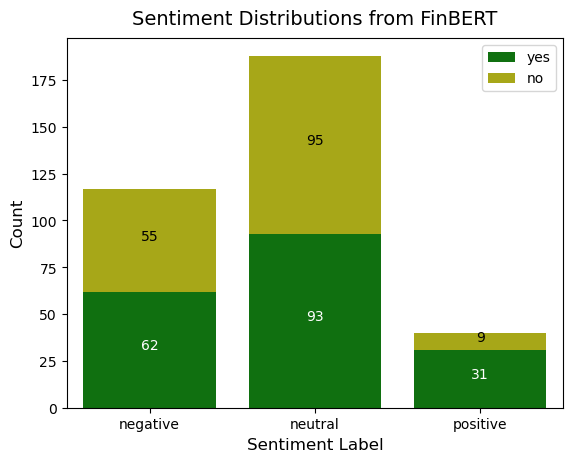

In [58]:
# plot the news sentiment distribution from FinBERT
counts = pd.crosstab(df_sa['description_label'], df_sa['one_shot_class'])

fig, ax = plt.subplots()

sns.barplot(x = counts.index, y = counts['yes'], color = 'g', label = 'yes', ax = ax)
sns.barplot(x = counts.index, y = counts['no'], bottom = counts['yes'], color = 'y', label = 'no', ax = ax)

i = 0
for patch in ax.patches:
    height = patch.get_height()   
    if i < 3:
        ax.text(
            patch.get_x() + patch.get_width()/2,
            height / 2.0,
            format(height, '1.0f'),
            color = 'white',
            ha = 'center'
        )
    else:
        ax.text(
            patch.get_x() + patch.get_width()/2,
            height/2 + counts['yes'][i-3],
            format(height, '1.0f'),
            ha = 'center'
        )
    i += 1

plt.legend()    
plt.title('Sentiment Distributions from FinBERT', fontsize = 14, pad = 10)
plt.xlabel('Sentiment Label', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
    
plt.show()

**Note:** 
* The majority news were neutral, which could be suprising given the common assumption that media outlets prefer to report negative news.
* There were more negative ones than positive ones.
    * This could be true.
    * Or related to FinBERT model's tendency to label positive Tesla-related news as neutral ones.

### 4.5.2. Sentiment polarity of publishers

In [99]:
# drop text in the dataframe and focus on News related to Tesla
df_label_all = df_sa.drop(labels = ['title', 'author', 'description', 'content', 'title_label', 'title_score', 'content_label', 'content_score', 'description_score', 'title_desc', 'title_desc_score', 'title_desc_label', 'label_high_score'], axis = 1)
df_label = df_label_all[df_label_all['one_shot_class'] == 'yes'].reset_index(drop = True)
df_label.head()

,source_name,date,one_shot_class,tesla_related,label,description_label
0,Fortune,2023-09-12,yes,yes,neutral,neutral
1,Financial Post,2023-09-12,yes,NaN,NaN,neutral
2,CNN,2023-09-12,yes,NaN,NaN,positive
3,Business Insider,2023-09-12,yes,NaN,NaN,neutral
4,TechCrunch,2023-09-12,yes,yes,neutral,neutral


In [101]:
# use positive rate and negative rate as sentiment polarity for each publisher
count1 = pd.DataFrame(df_label.groupby('source_name')['description_label'].apply(lambda x: x[x =='negative'].count() / x.count()).reset_index())
count2 = pd.DataFrame(df_label.groupby('source_name')['description_label'].apply(lambda x: x[x =='positive'].count() / x.count()).reset_index())
count3 = pd.merge(count1, count2, on = 'source_name', how = 'left')
count3['polarity'] = count3['description_label_y'] - count3['description_label_x']
count3 = count3.sort_values(by = ['polarity'], ascending = True)
count3.head()

,source_name,description_label_x,description_label_y,polarity
15,NBC News,1.000000,0.0,-1.000000
25,The Irish Times,1.000000,0.0,-1.000000
20,Politico,1.000000,0.0,-1.000000
29,The Washington Post,0.800000,0.0,-0.800000
5,Breitbart News,0.692308,0.0,-0.692308


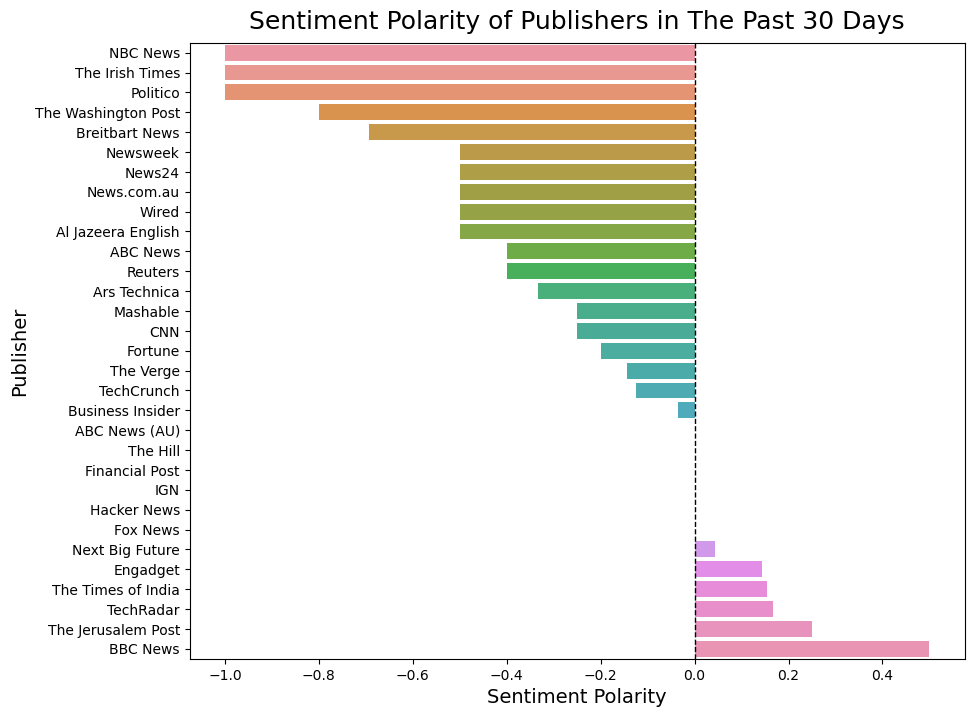

In [102]:
# plot the polarities
plt.figure(figsize = (10, 8))
sns.barplot(data = count3, y = 'source_name', x = 'polarity')
plt.axvline(x = 0, color = 'k', linestyle = '--', linewidth = 1)

plt.title('Sentiment Polarity of Publishers in The Past 30 Days', fontsize = 18, pad = 10)
plt.xlabel('Sentiment Polarity', fontsize = 14)
plt.ylabel('Publisher', fontsize = 14)

plt.show()

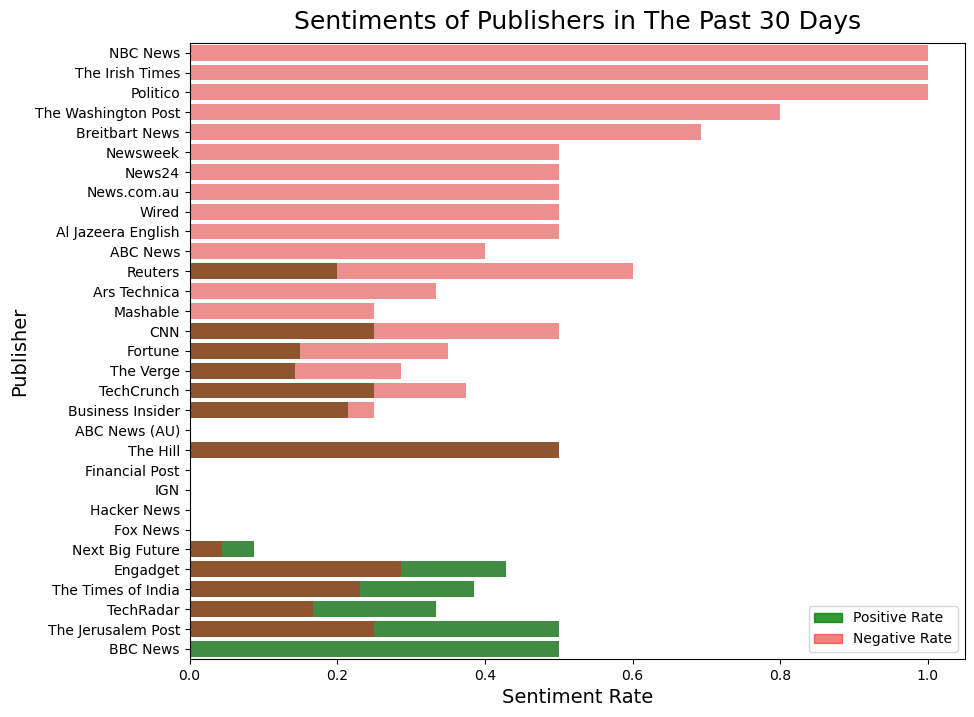

In [103]:
# plot the the negative and positive rates for each publisher
plt.figure(figsize = (10, 8))
bar1 = sns.barplot(data = count3, y = 'source_name', x = 'description_label_y', color = 'g', alpha = 0.8)
bar2 = sns.barplot(data = count3, y = 'source_name', x = 'description_label_x', color = 'r', alpha = 0.5)

positive_patch = mpatches.Patch(color='g', label='Positive Rate', alpha = 0.8)
negative_patch = mpatches.Patch(color='r', label='Negative Rate', alpha = 0.5)
plt.legend(handles=[positive_patch, negative_patch])

plt.title('Sentiments of Publishers in The Past 30 Days', fontsize = 18, pad = 10)
plt.xlabel('Sentiment Rate', fontsize = 14)
plt.ylabel('Publisher', fontsize = 14)

plt.show()

**Notes:**
* The majority publishers are more on neutral side.
* There are some publishers tended to report more negative Tesla news, such as NBC News, The Irish Times, Politico, , The Washington Post and Breitbart News.
    * Some the publishers above are big names, such as NBC News and The Washington Post that could have a larger impact on public opinion on how Tesla is doing.
* There are some publishers tended to report more positive Tesla news, such as Next Big Future, Engadget, The Times of India, TechRadar, The Jerusalem Post and BBC News.
    * This trend suggests that technology-focused publishers generally maintain a positive stance towards Tesla.
    * Major publishers from specific countries appeared to be more positive in their coverage of Tesla, which could indicate a favorable disposition towards providing Tesla with better opportunities.
* It is worth to mention that BBC News only reported positive and neutral news about Tesla in the past 30 days.

## 4.6. Sentiment Results vs Stock Price Movements
All news and those only related to Tesla will be used for this analysis.

In [105]:
# check all news data
df_label_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   source_name        345 non-null    object
 1   date               345 non-null    object
 2   one_shot_class     345 non-null    object
 3   tesla_related      207 non-null    object
 4   label              207 non-null    object
 5   description_label  345 non-null    object
dtypes: object(6)
memory usage: 16.3+ KB


In [106]:
# check data only related to Tesla
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   source_name        186 non-null    object
 1   date               186 non-null    object
 2   one_shot_class     186 non-null    object
 3   tesla_related      110 non-null    object
 4   label              110 non-null    object
 5   description_label  186 non-null    object
dtypes: object(6)
memory usage: 8.8+ KB


### 4.6.1. Create Sentiment Features

Now there are sentiment results of multiple articles for each day. 

Need to create some sentiment features for each day in order to investigating its impact on stock price's daily movements.

In [107]:
# define a function to create total number and rates for each label for each day
def daily_sentiments(data, col):
    
    # calculate the number/rate of different types of news for each day
    df_news_negr = pd.DataFrame(data.groupby('date')[col].apply(lambda x: x[x =='negative'].count() / x.count()).reset_index())
    df_news_posr = pd.DataFrame(data.groupby('date')[col].apply(lambda x: x[x =='positive'].count() / x.count()).reset_index())
    df_news_ntrr = pd.DataFrame(data.groupby('date')[col].apply(lambda x: x[x =='neutral'].count() / x.count()).reset_index())
    df_news_neg = pd.DataFrame(data.groupby('date')[col].apply(lambda x: x[x =='negative'].count()).reset_index())
    df_news_pos = pd.DataFrame(data.groupby('date')[col].apply(lambda x: x[x =='positive'].count()).reset_index())
    df_news_ntr = pd.DataFrame(data.groupby('date')[col].apply(lambda x: x[x =='neutral'].count()).reset_index())

    # merge the data above
    df_news_rates = pd.merge(df_news_pos, df_news_neg, on = 'date', how = 'inner')
    df_news_rates = pd.merge(df_news_rates, df_news_ntr, on = 'date', how = 'inner')
    df_news_rates = pd.merge(df_news_rates, df_news_posr, on = 'date', how = 'inner')
    df_news_rates = pd.merge(df_news_rates, df_news_negr, on = 'date', how = 'inner')
    df_news_rates = pd.merge(df_news_rates, df_news_ntrr, on = 'date', how = 'inner')
    
    # rename columns
    df_news_rates.columns = ['date', 'positive_num', 'negative_num', 'nuetral_num', 'positive_rate', 'negative_rate', 'neutral_rate']

    return df_news_rates

In [109]:
# calculate daily sentiments for all news
df_all_daily = daily_sentiments(df_label_all, 'description_label')
df_all_daily.head()

C:\Users\wfei2\AppData\Local\Temp\ipykernel_12000\3767212645.py:15: FutureWarning: Passing 'suffixes' which cause duplicate columns {'description_label_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_news_rates = pd.merge(df_news_rates, df_news_posr, on = 'date', how = 'inner')
C:\Users\wfei2\AppData\Local\Temp\ipykernel_12000\3767212645.py:17: FutureWarning: Passing 'suffixes' which cause duplicate columns {'description_label_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_news_rates = pd.merge(df_news_rates, df_news_ntrr, on = 'date', how = 'inner')


,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate
0,2023-09-12,3,2,16,0.142857,0.095238,0.761905
1,2023-09-13,2,5,21,0.071429,0.178571,0.750000
2,2023-09-14,3,11,9,0.130435,0.478261,0.391304
3,2023-09-15,3,5,6,0.214286,0.357143,0.428571
4,2023-09-16,1,0,1,0.500000,0.000000,0.500000


In [179]:
df_all_daily['date'] = pd.to_datetime(df_all_daily['date'])
df_all_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           30 non-null     datetime64[ns]
 1   positive_num   30 non-null     int64         
 2   negative_num   30 non-null     int64         
 3   nuetral_num    30 non-null     int64         
 4   positive_rate  30 non-null     float64       
 5   negative_rate  30 non-null     float64       
 6   neutral_rate   30 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 1.9 KB


In [178]:
# calculate daily sentiments for Tesla news only
df_tesla_daily = daily_sentiments(df_label, 'description_label')
df_tesla_daily.head()

C:\Users\wfei2\AppData\Local\Temp\ipykernel_12000\3767212645.py:15: FutureWarning: Passing 'suffixes' which cause duplicate columns {'description_label_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_news_rates = pd.merge(df_news_rates, df_news_posr, on = 'date', how = 'inner')
C:\Users\wfei2\AppData\Local\Temp\ipykernel_12000\3767212645.py:17: FutureWarning: Passing 'suffixes' which cause duplicate columns {'description_label_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_news_rates = pd.merge(df_news_rates, df_news_ntrr, on = 'date', how = 'inner')


,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate
0,2023-09-12,2,0,5,0.285714,0.000000,0.714286
1,2023-09-13,2,1,12,0.133333,0.066667,0.800000
2,2023-09-14,2,4,4,0.200000,0.400000,0.400000
3,2023-09-15,2,1,4,0.285714,0.142857,0.571429
4,2023-09-16,1,0,0,1.000000,0.000000,0.000000


In [181]:
df_tesla_daily['date'] = pd.to_datetime(df_tesla_daily['date'])
df_tesla_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 27
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           28 non-null     datetime64[ns]
 1   positive_num   28 non-null     int64         
 2   negative_num   28 non-null     int64         
 3   nuetral_num    28 non-null     int64         
 4   positive_rate  28 non-null     float64       
 5   negative_rate  28 non-null     float64       
 6   neutral_rate   28 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 1.8 KB


**Note:** There were days without Tesla related news in the past 30 days.

In [175]:
# get period of interest
period_days = 30

In [186]:
# fillin missing dates
print('Need to fillin dates.')
# fillin missing dates
#end_day = datetime.now().date() - timedelta(days = 1)
end_day = '2023-10-11'
print(end_day)
#start_day = end_day - timedelta(days = period_days - 1)
start_day = '2023-09-12'
print(start_day)

all_days = pd.date_range(start=str(start_day), end = str(end_day))
df_alldates = pd.DataFrame(all_days, columns = ['date'])
df_tesla_daily = pd.merge(df_alldates, df_tesla_daily, on = 'date', how = 'left')
df_tesla_daily

Need to fillin dates.
2023-10-11
2023-09-12


,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate
0,2023-09-12,2.0,0.0,5.0,0.285714,0.000000,0.714286
1,2023-09-13,2.0,1.0,12.0,0.133333,0.066667,0.800000
2,2023-09-14,2.0,4.0,4.0,0.200000,0.400000,0.400000
3,2023-09-15,2.0,1.0,4.0,0.285714,0.142857,0.571429
4,2023-09-16,1.0,0.0,0.0,1.000000,0.000000,0.000000
5,2023-09-17,0.0,2.0,1.0,0.000000,0.666667,0.333333
6,2023-09-18,6.0,6.0,13.0,0.240000,0.240000,0.520000
7,2023-09-19,1.0,3.0,3.0,0.142857,0.428571,0.428571
8,2023-09-20,1.0,2.0,4.0,0.142857,0.285714,0.571429
9,2023-09-21,1.0,2.0,1.0,0.250000,0.500000,0.250000


### 4.6.2. Stock Market Data Wrangling

In [116]:
# read in stock data
df_stock = pd.read_csv('../data/Tesla_stock.csv')
df_stock.head()

,date,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,datetime,inday_move,yesterday_move
0,2023-08-30,254.200,260.5100,250.59,256.90,121988437.0,260.5100,250.59,256.90,254.200,121988437.0,1.0,0.0,TSLA,XNAS,2023-08-30 00:00:00+00:00,2.700,NaN
1,2023-08-31,255.980,261.1800,255.05,258.08,108861698.0,261.1800,255.05,258.08,255.980,108861698.0,1.0,0.0,TSLA,XNAS,2023-08-31 00:00:00+00:00,2.100,1.18
2,2023-09-01,257.260,259.0794,242.01,245.01,132541640.0,259.0794,242.01,245.01,257.260,132541640.0,1.0,0.0,TSLA,XNAS,2023-09-01 00:00:00+00:00,-12.250,-13.07
3,2023-09-05,245.000,258.0000,244.86,256.49,129469565.0,258.0000,244.86,256.49,245.000,129469565.0,1.0,0.0,TSLA,XNAS,2023-09-05 00:00:00+00:00,11.490,11.48
4,2023-09-06,255.135,255.3900,245.06,251.92,116959759.0,255.3900,245.06,251.92,255.135,116959759.0,1.0,0.0,TSLA,XNAS,2023-09-06 00:00:00+00:00,-3.215,-4.57


In [117]:
# check data
df_stock['date'] = pd.to_datetime(df_stock['date'])
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            30 non-null     datetime64[ns]
 1   open            30 non-null     float64       
 2   high            30 non-null     float64       
 3   low             30 non-null     float64       
 4   close           30 non-null     float64       
 5   volume          30 non-null     float64       
 6   adj_high        30 non-null     float64       
 7   adj_low         30 non-null     float64       
 8   adj_close       30 non-null     float64       
 9   adj_open        30 non-null     float64       
 10  adj_volume      30 non-null     float64       
 11  split_factor    30 non-null     float64       
 12  dividend        30 non-null     float64       
 13  symbol          30 non-null     object        
 14  exchange        30 non-null     object        
 15  datetime

In [183]:
# combine the two dataframe for all news
df_combine_all = pd.merge(df_all_daily, df_stock, on = 'date', how = 'left')
df_combine_all.head()

,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate,open,high,low,...,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,datetime,inday_move,yesterday_move
0,2023-09-12,3,2,16,0.142857,0.095238,0.761905,270.76,278.3900,266.60,...,267.48,270.76,135999866.0,1.0,0.0,TSLA,XNAS,2023-09-12 00:00:00+00:00,-3.28,-6.10
1,2023-09-13,2,5,21,0.071429,0.178571,0.750000,270.07,274.9800,268.10,...,271.30,270.07,111673737.0,1.0,0.0,TSLA,XNAS,2023-09-13 00:00:00+00:00,1.23,3.82
2,2023-09-14,3,11,9,0.130435,0.478261,0.391304,271.32,276.7094,270.42,...,276.04,271.32,107709842.0,1.0,0.0,TSLA,XNAS,2023-09-14 00:00:00+00:00,4.72,4.74
3,2023-09-15,3,5,6,0.214286,0.357143,0.428571,277.55,278.9800,271.00,...,274.39,277.55,133692313.0,1.0,0.0,TSLA,XNAS,2023-09-15 00:00:00+00:00,-3.16,-1.65
4,2023-09-16,1,0,1,0.500000,0.000000,0.500000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Note:** Stock market data missing for weekends and US holidays.

In [187]:
# combine the two dataframe for Tesla related news
df_combine_tesla = pd.merge(df_tesla_daily, df_stock, on = 'date', how = 'left')
df_combine_tesla.head()

,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate,open,high,low,...,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,datetime,inday_move,yesterday_move
0,2023-09-12,2.0,0.0,5.0,0.285714,0.000000,0.714286,270.76,278.3900,266.60,...,267.48,270.76,135999866.0,1.0,0.0,TSLA,XNAS,2023-09-12 00:00:00+00:00,-3.28,-6.10
1,2023-09-13,2.0,1.0,12.0,0.133333,0.066667,0.800000,270.07,274.9800,268.10,...,271.30,270.07,111673737.0,1.0,0.0,TSLA,XNAS,2023-09-13 00:00:00+00:00,1.23,3.82
2,2023-09-14,2.0,4.0,4.0,0.200000,0.400000,0.400000,271.32,276.7094,270.42,...,276.04,271.32,107709842.0,1.0,0.0,TSLA,XNAS,2023-09-14 00:00:00+00:00,4.72,4.74
3,2023-09-15,2.0,1.0,4.0,0.285714,0.142857,0.571429,277.55,278.9800,271.00,...,274.39,277.55,133692313.0,1.0,0.0,TSLA,XNAS,2023-09-15 00:00:00+00:00,-3.16,-1.65
4,2023-09-16,1.0,0.0,0.0,1.000000,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4.6.3. Tesla Stock Price Movements vs News Sentiment Results

In [188]:
# select cols for analysis
cols = ['date', 'positive_num', 'negative_num', 'nuetral_num', 'positive_rate', 'negative_rate', 'neutral_rate', 'open', 'close', 'inday_move', 'yesterday_move']
df_all = df_combine_all[cols]
df_all.head()

,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate,open,close,inday_move,yesterday_move
0,2023-09-12,3,2,16,0.142857,0.095238,0.761905,270.76,267.48,-3.28,-6.10
1,2023-09-13,2,5,21,0.071429,0.178571,0.750000,270.07,271.30,1.23,3.82
2,2023-09-14,3,11,9,0.130435,0.478261,0.391304,271.32,276.04,4.72,4.74
3,2023-09-15,3,5,6,0.214286,0.357143,0.428571,277.55,274.39,-3.16,-1.65
4,2023-09-16,1,0,1,0.500000,0.000000,0.500000,NaN,NaN,NaN,NaN


In [189]:
# check for missing data
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            30 non-null     datetime64[ns]
 1   positive_num    30 non-null     int64         
 2   negative_num    30 non-null     int64         
 3   nuetral_num     30 non-null     int64         
 4   positive_rate   30 non-null     float64       
 5   negative_rate   30 non-null     float64       
 6   neutral_rate    30 non-null     float64       
 7   open            22 non-null     float64       
 8   close           22 non-null     float64       
 9   inday_move      22 non-null     float64       
 10  yesterday_move  22 non-null     float64       
dtypes: datetime64[ns](1), float64(7), int64(3)
memory usage: 2.8 KB


In [190]:
# save the data
df_all.to_csv('../data/Sentiments_and_Stock_Prices_All.csv', index = False)

In [191]:
# load the data
df_all = pd.read_csv('../data/Sentiments_and_Stock_Prices_All.csv')
df_all.head(1)

,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate,open,close,inday_move,yesterday_move
0,2023-09-12,3,2,16,0.142857,0.095238,0.761905,270.76,267.48,-3.28,-6.1


In [192]:
# select cols for analysis
cols = ['date', 'positive_num', 'negative_num', 'nuetral_num', 'positive_rate', 'negative_rate', 'neutral_rate', 'open', 'close', 'inday_move', 'yesterday_move']
df_tesla = df_combine_tesla[cols]
df_tesla.head()

,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate,open,close,inday_move,yesterday_move
0,2023-09-12,2.0,0.0,5.0,0.285714,0.000000,0.714286,270.76,267.48,-3.28,-6.10
1,2023-09-13,2.0,1.0,12.0,0.133333,0.066667,0.800000,270.07,271.30,1.23,3.82
2,2023-09-14,2.0,4.0,4.0,0.200000,0.400000,0.400000,271.32,276.04,4.72,4.74
3,2023-09-15,2.0,1.0,4.0,0.285714,0.142857,0.571429,277.55,274.39,-3.16,-1.65
4,2023-09-16,1.0,0.0,0.0,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN


In [193]:
# save the data
df_tesla.to_csv('../data/Sentiments_and_Stock_Prices_Tesla.csv', index = False)

In [195]:
# load the data
df_tesla = pd.read_csv('../data/Sentiments_and_Stock_Prices_Tesla.csv')
df_tesla.head(1)

,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate,open,close,inday_move,yesterday_move
0,2023-09-12,2.0,0.0,5.0,0.285714,0.0,0.714286,270.76,267.48,-3.28,-6.1


C:\Users\wfei2\AppData\Local\Temp\ipykernel_12000\2429763893.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_all.corr()


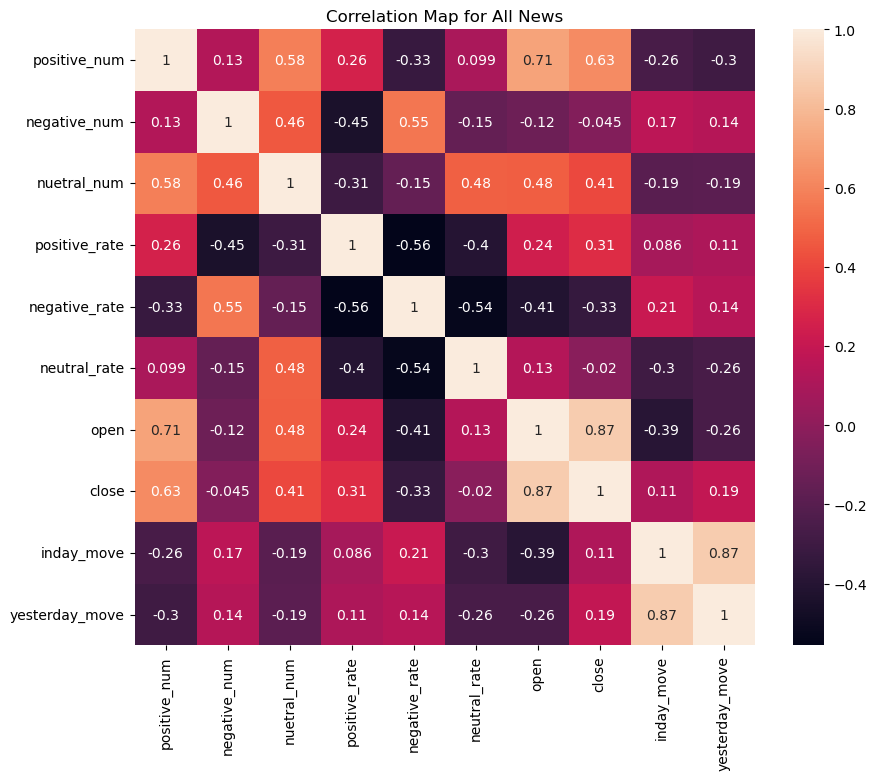

In [196]:
# check correlations first
corr_matrix = df_all.corr()

plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True)
plt.title('Correlation Map for All News')
plt.show()

C:\Users\wfei2\AppData\Local\Temp\ipykernel_12000\1896816057.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_tesla.corr()


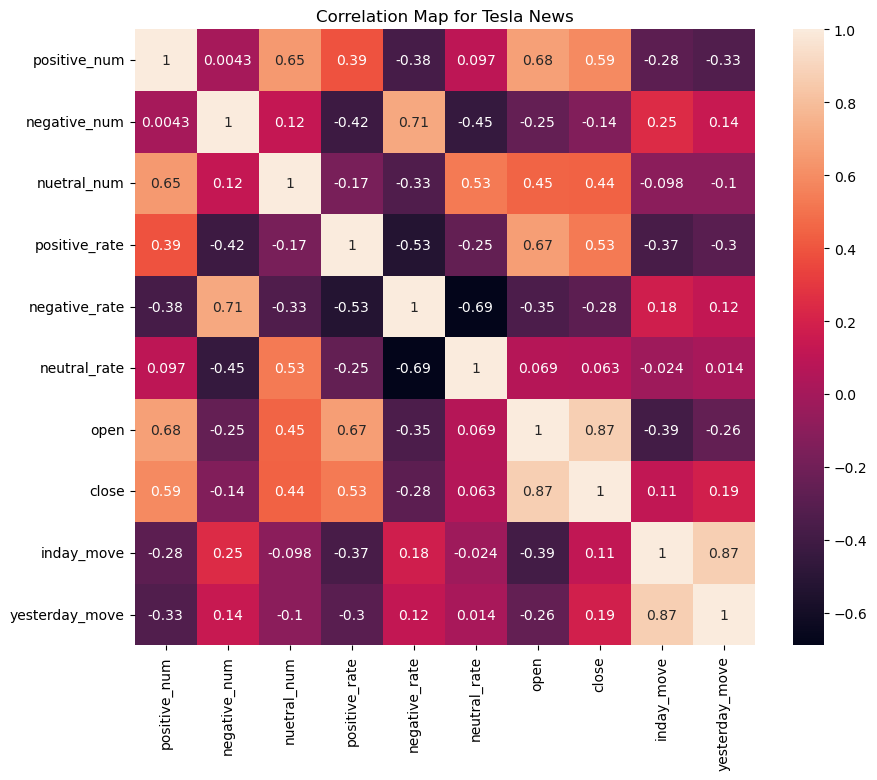

In [197]:
# check correlations first
corr_matrix = df_tesla.corr()

plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True)
plt.title('Correlation Map for Tesla News')
plt.show()

**Note:**
* Pearson correlation coefficient describes whether there is linear correlation between two parameters or not.
* It is worth to check how open/close price changes with positive_num due to high correlation values in the heatmap.

### 4.6.4. Open Price *VS* Number of Positive News

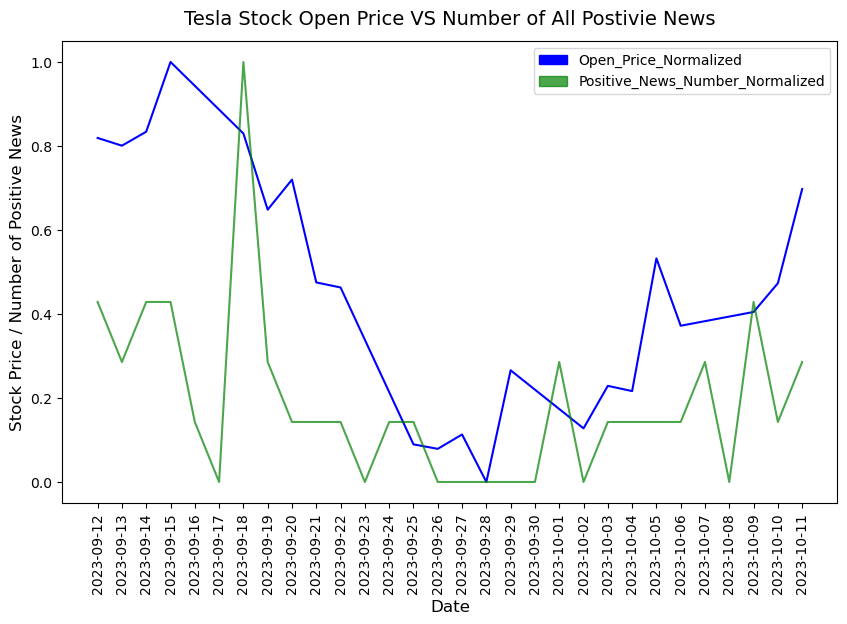

In [201]:
# first plot data for all news
plt.figure(figsize = (10, 6))
df_all['open_norm'] = (df_all['open']-df_all['open'].min())/(df_all['open'].max()-df_all['open'].min())
df_all['positive_num_norm'] = (df_all['positive_num']-df_all['positive_num'].min())/(df_all['positive_num'].max()-df_all['positive_num'].min())
sns.lineplot(data = df_all, x = 'date', y = 'open_norm', color = 'b')
sns.lineplot(data = df_all, x = 'date', y = 'positive_num_norm', color = 'g', alpha = 0.7)
bar1 = mpatches.Patch(color = 'b', label = 'Open_Price_Normalized')
bar2 = mpatches.Patch(color = 'g', label = 'Positive_News_Number_Normalized', alpha = 0.7)
plt.legend(handles = [bar1, bar2])
plt.xticks(rotation = 90)
plt.title('Tesla Stock Open Price VS Number of All Postivie News', fontsize = 14, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Stock Price / Number of Positive News', fontsize = 12)
plt.show()

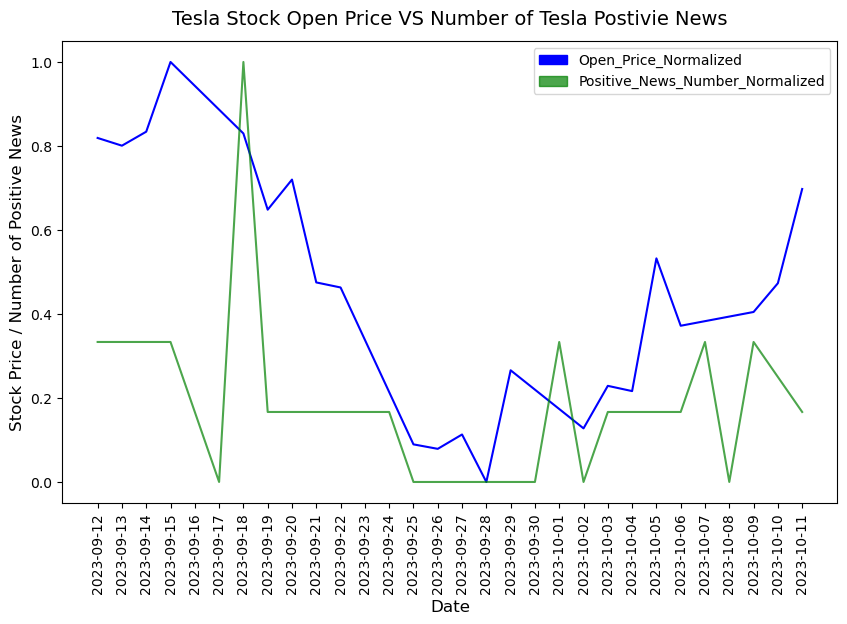

In [198]:
# first plot data for all news
plt.figure(figsize = (10, 6))
df_tesla['open_norm'] = (df_tesla['open']-df_tesla['open'].min())/(df_tesla['open'].max()-df_tesla['open'].min())
df_tesla['positive_num_norm'] = (df_tesla['positive_num']-df_tesla['positive_num'].min())/(df_tesla['positive_num'].max()-df_tesla['positive_num'].min())
sns.lineplot(data = df_tesla, x = 'date', y = 'open_norm', color = 'b')
sns.lineplot(data = df_tesla, x = 'date', y = 'positive_num_norm', color = 'g', alpha = 0.7)
bar1 = mpatches.Patch(color = 'b', label = 'Open_Price_Normalized')
bar2 = mpatches.Patch(color = 'g', label = 'Positive_News_Number_Normalized', alpha = 0.7)
plt.legend(handles = [bar1, bar2])
plt.xticks(rotation = 90)
plt.title('Tesla Stock Open Price VS Number of Tesla Postivie News', fontsize = 14, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Stock Price / Number of Positive News', fontsize = 12)
plt.show()

**Note:** 
* Tesla's stock open price demonstrated similar trend as number of positive news reported daily.
* In order to form an investiment strategy on Tesla stocks, we need to predict how the open price will change based on news reported in the past.
* Next will compare Tesla stock open price trend with positive news number reported in the yesterday, shift 1 day.

In [203]:
# let's shift the news to the left side by 1 day to check if news from the previous day has any obvious impact on the open price of today
df_all.loc[:,'positive_num_norm_shift_1'] = df_all['positive_num_norm'].shift(1)
df_all.head(3)

,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate,open,close,inday_move,yesterday_move,open_norm,positive_num_norm,positive_num_norm_shift_1
0,2023-09-12,3,2,16,0.142857,0.095238,0.761905,270.76,267.48,-3.28,-6.10,0.819078,0.428571,NaN
1,2023-09-13,2,5,21,0.071429,0.178571,0.750000,270.07,271.30,1.23,3.82,0.800693,0.285714,0.428571
2,2023-09-14,3,11,9,0.130435,0.478261,0.391304,271.32,276.04,4.72,4.74,0.833999,0.428571,0.285714


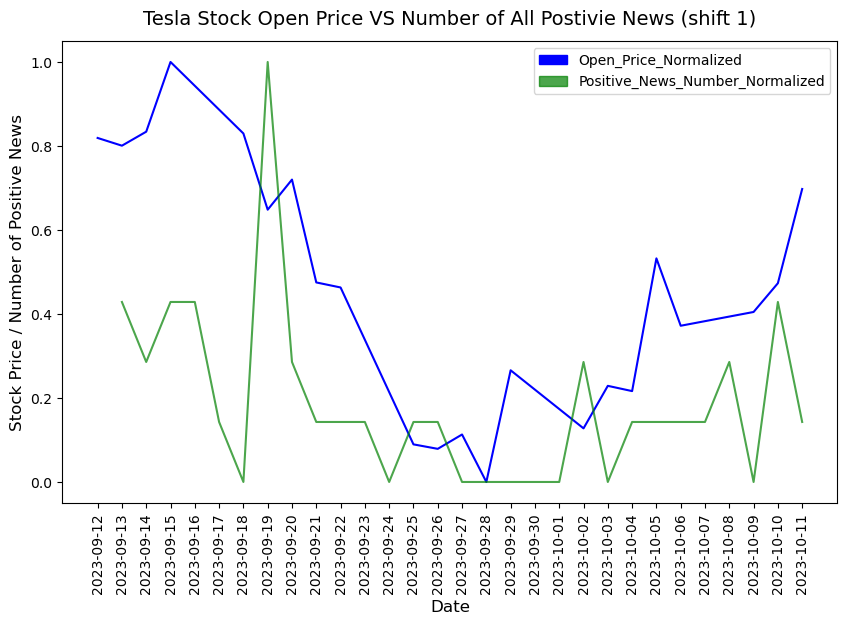

In [204]:
# first plot data for all news
plt.figure(figsize = (10, 6))
sns.lineplot(data = df_all, x = 'date', y = 'open_norm', color = 'b')
sns.lineplot(data = df_all, x = 'date', y = 'positive_num_norm_shift_1', color = 'g', alpha = 0.7)
bar1 = mpatches.Patch(color = 'b', label = 'Open_Price_Normalized')
bar2 = mpatches.Patch(color = 'g', label = 'Positive_News_Number_Normalized', alpha = 0.7)
plt.legend(handles = [bar1, bar2])
plt.xticks(rotation = 90)
plt.title("Tesla Stock Open Price VS Number of All Postivie News (shift 1)", fontsize = 14, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Stock Price / Number of Positive News', fontsize = 12)
plt.show()

In [207]:
# let's shift the news to the left side by 1 day to check if news from the previous day has any obvious impact on the open price of today
df_tesla.loc[:,'positive_num_norm_shift_1'] = df_tesla['positive_num_norm'].shift(1)
df_tesla.tail(3)

,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate,open,close,inday_move,yesterday_move,open_norm,positive_num_norm,positive_num_norm_shift_1
27,2023-10-09,2.0,2.0,3.0,0.285714,0.285714,0.428571,255.21,259.67,4.46,-0.86,0.404743,0.333333,0.000000
28,2023-10-10,NaN,NaN,NaN,NaN,NaN,NaN,257.78,263.62,5.84,3.95,0.473221,NaN,0.333333
29,2023-10-11,1.0,1.0,1.0,0.333333,0.333333,0.333333,266.20,262.99,-3.21,-0.63,0.697575,0.166667,NaN


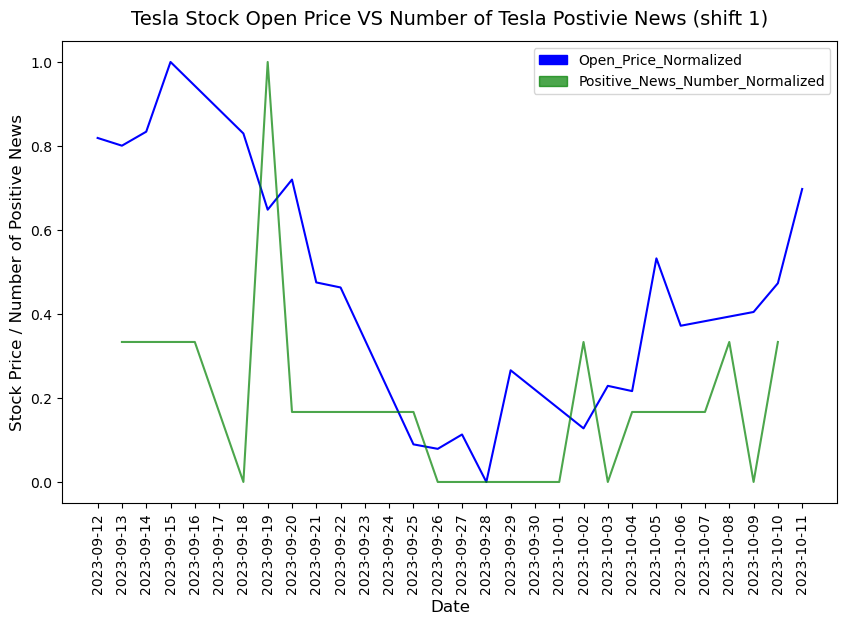

In [206]:
# first plot data for tesla news
plt.figure(figsize = (10, 6))
sns.lineplot(data = df_tesla, x = 'date', y = 'open_norm', color = 'b')
sns.lineplot(data = df_tesla, x = 'date', y = 'positive_num_norm_shift_1', color = 'g', alpha = 0.7)
bar1 = mpatches.Patch(color = 'b', label = 'Open_Price_Normalized')
bar2 = mpatches.Patch(color = 'g', label = 'Positive_News_Number_Normalized', alpha = 0.7)
plt.legend(handles = [bar1, bar2])
plt.xticks(rotation = 90)
plt.title('Tesla Stock Open Price VS Number of Tesla Postivie News (shift 1)', fontsize = 14, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Stock Price / Number of Positive News', fontsize = 12)
plt.show()

**Note:**
* There is no clear correlation between today's open price with yesterday's number of positive news.
* Next let's investigate the impact from both positive and negative news on Tesla stock price change.

### 4.6.5. Dominant News Sentiments (Neutral Ignored) *VS* Stock Price Move

In [209]:
# calcualte abosolute difference between positive and negative news number
df_all.loc[:, 'pos_neg_diff'] = df_all.loc[:, 'positive_num'] - df_all.loc[:, 'negative_num']
df_all.head(3)

,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate,open,close,inday_move,yesterday_move,open_norm,positive_num_norm,positive_num_norm_shift_1,pos_neg_diff
0,2023-09-12,3,2,16,0.142857,0.095238,0.761905,270.76,267.48,-3.28,-6.10,0.819078,0.428571,NaN,1
1,2023-09-13,2,5,21,0.071429,0.178571,0.750000,270.07,271.30,1.23,3.82,0.800693,0.285714,0.428571,-3
2,2023-09-14,3,11,9,0.130435,0.478261,0.391304,271.32,276.04,4.72,4.74,0.833999,0.428571,0.285714,-8


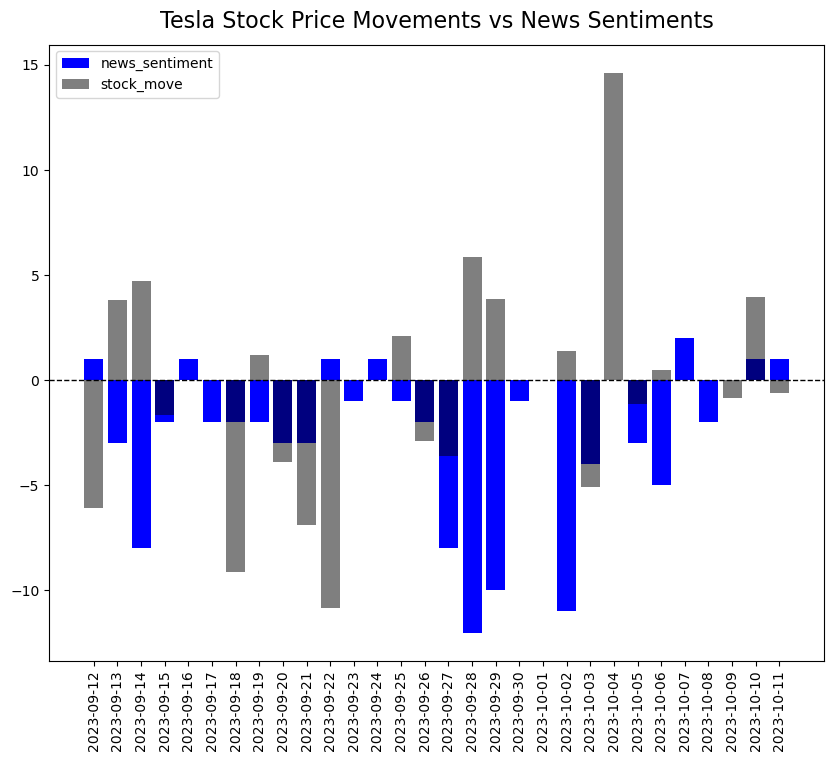

In [231]:
# create a bar plot to compared stock price change and news sentiments
plt.figure(figsize = (10, 8))
plt.bar(df_all['date'], df_all['pos_neg_diff'], color = 'b')
plt.bar(df_all['date'], df_all['yesterday_move'], color = 'k', alpha = 0.5)

plt.legend(['news_sentiment', 'stock_move'], loc = 'upper left')
plt.axhline(y = 0, color = 'k', linestyle = '--', linewidth = 1)
plt.xticks(df_all['date'], rotation = 90)
plt.title('Tesla Stock Price Movements vs News Sentiments', fontsize = 16, pad = 12)

plt.show()

In [212]:
# calcualte abosolute difference between positive and negative news number
df_tesla.loc[:, 'pos_neg_diff'] = df_tesla.loc[:, 'positive_num'] - df_tesla.loc[:, 'negative_num']
df_tesla.head(3)

,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate,open,close,inday_move,yesterday_move,open_norm,positive_num_norm,positive_num_norm_shift_1,pos_neg_diff
0,2023-09-12,2.0,0.0,5.0,0.285714,0.000000,0.714286,270.76,267.48,-3.28,-6.10,0.819078,0.333333,NaN,2.0
1,2023-09-13,2.0,1.0,12.0,0.133333,0.066667,0.800000,270.07,271.30,1.23,3.82,0.800693,0.333333,0.333333,1.0
2,2023-09-14,2.0,4.0,4.0,0.200000,0.400000,0.400000,271.32,276.04,4.72,4.74,0.833999,0.333333,0.333333,-2.0


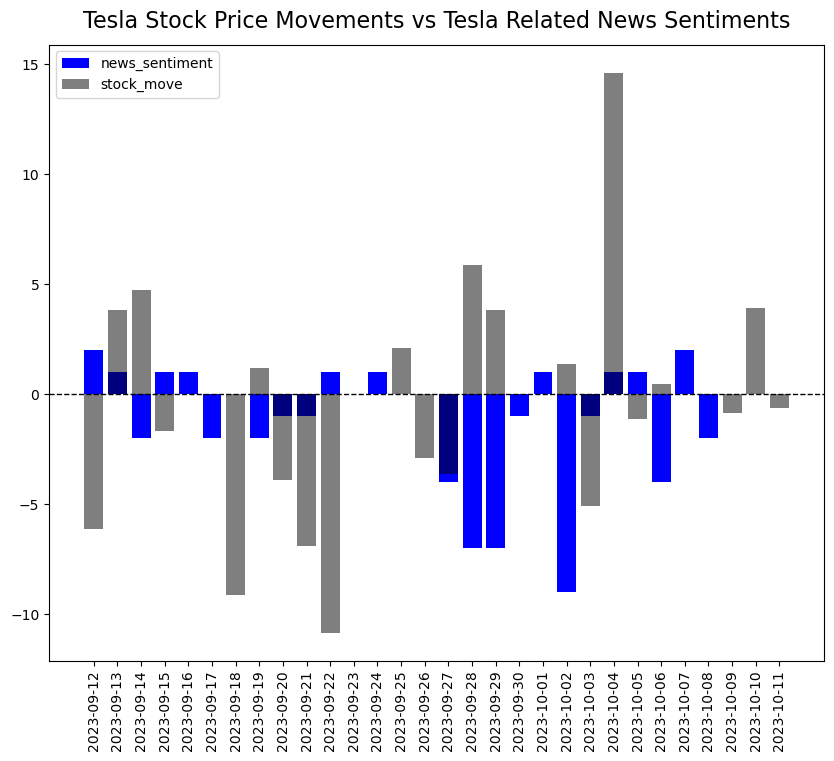

In [230]:
# create a bar plot to compared stock price change and news sentiments
plt.figure(figsize = (10, 8))
plt.bar(df_tesla['date'], df_tesla['pos_neg_diff'], color = 'b')
plt.bar(df_tesla['date'], df_tesla['yesterday_move'], color = 'k', alpha = 0.5)

plt.legend(['news_sentiment', 'stock_move'], loc = 'upper left')
plt.axhline(y = 0, color = 'k', linestyle = '--', linewidth = 1)
plt.xticks(df_tesla['date'], rotation = 90)
plt.title('Tesla Stock Price Movements vs Tesla Related News Sentiments', fontsize = 16, pad = 12)

plt.show()

**Note:**
* If the news sentiments have clear impact on the stock prices. The stock price movements are expected to show same polarity (positive or negative) as the news_sentiment.
* There is no clear correlation between the stock price change and the sentiment results.
* Sentiments from all news were dominated by negative news. Better to check just Tesla-related news.
* Considering the possibility of delayed impact from news on stock prices, it is worth to combine the news sentiments and stock price movement from a period of time then check the bar plot again.

In [228]:
# define a function to plot averaged impact of news in the past
def get_plot(data, pastdays):
    data.loc[:,'diff_past'] = data['pos_neg_diff'].shift(1).rolling(window = pastdays).mean()
    plt.figure(figsize = (10, 8))
    plt.bar(data['date'], data['diff_past'], color = 'g')
    plt.bar(data['date'], data['close'].diff(pastdays), color = 'k', alpha = 0.5)
    plt.legend(['news_sentiment_period', 'stock_move'], loc = 'upper left')
    plt.axhline(y = 0, color = 'k', linestyle = '--', linewidth = 1)
    plt.title('Tesla Stock Price Movements vs News Sentiments (accumulated from the previous {}days)'.format(pastdays), fontsize = 16, pad = 12)
    plt.xticks(data['date'], rotation = 90)
    plt.show()

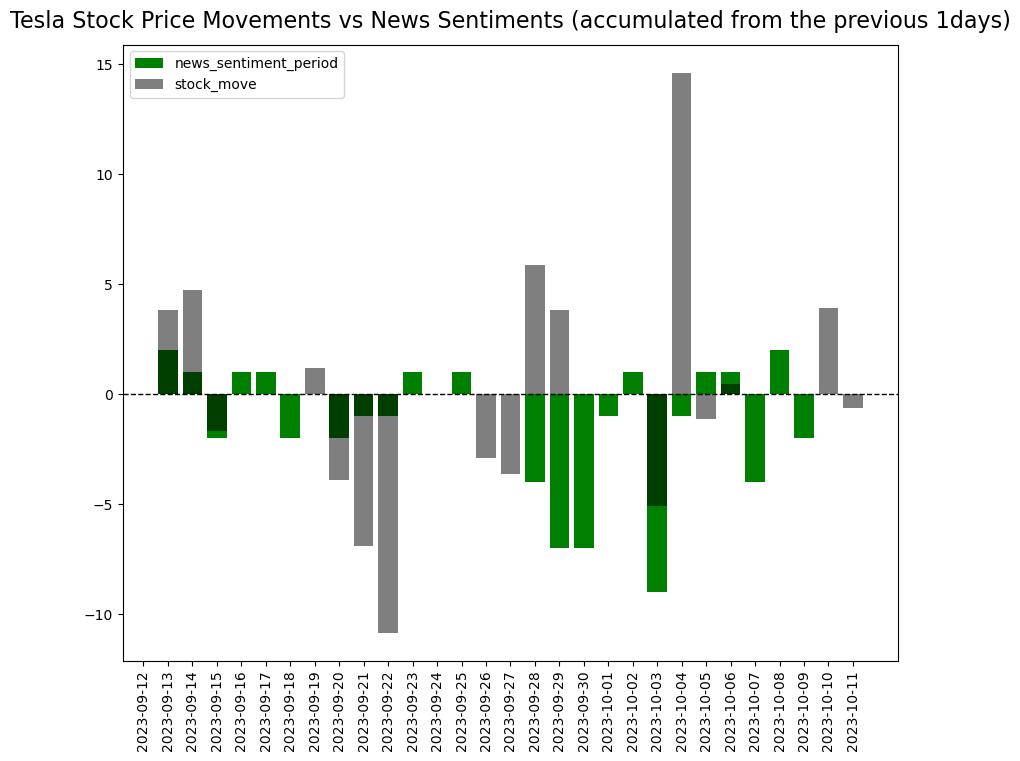

In [229]:
# let check impact from 1 day ago
get_plot(df_tesla, 1)

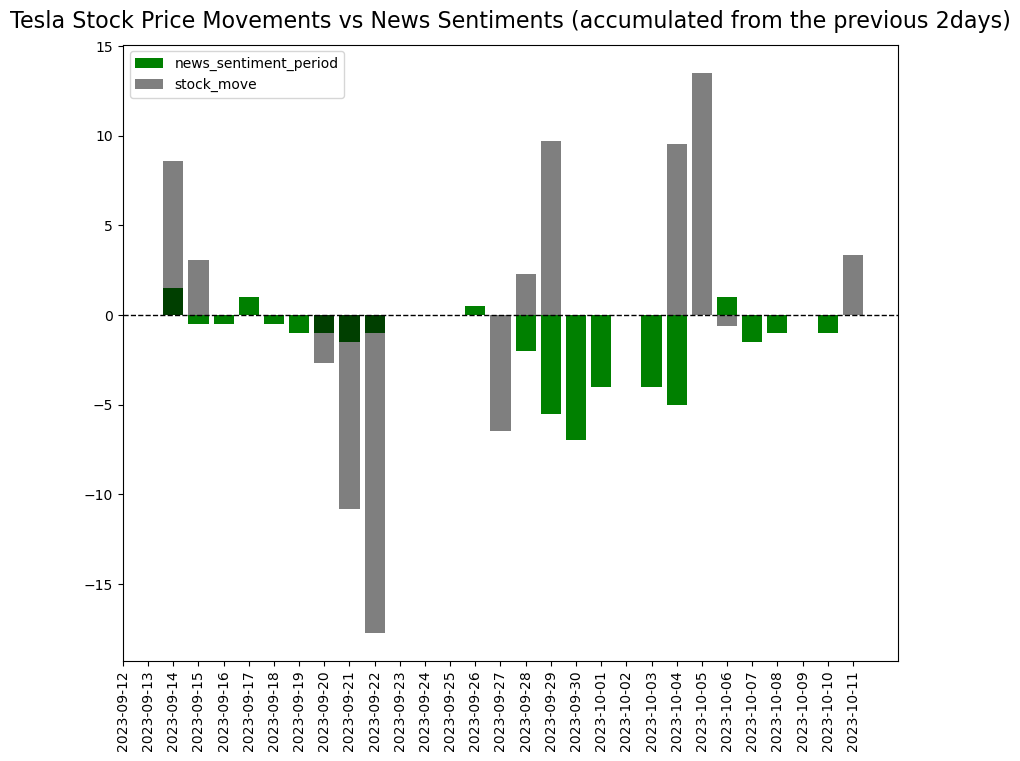

In [224]:
# let check impact from 2 days ago
get_plot(df_tesla, 2)

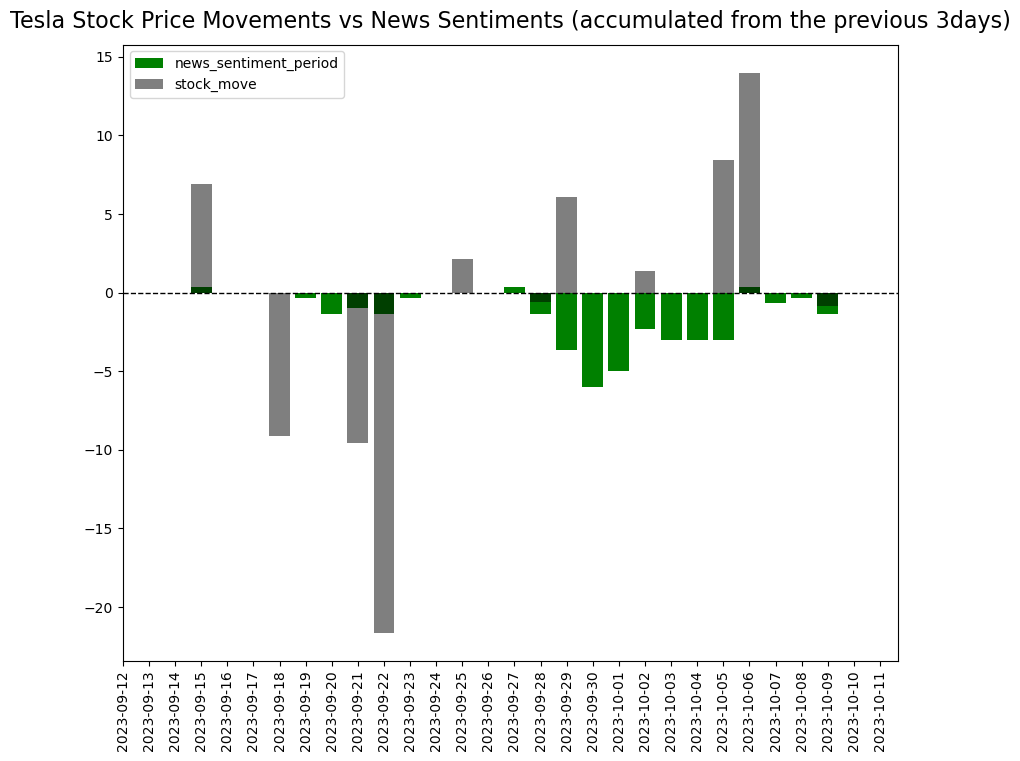

In [225]:
# let check impact from previous 3 days
get_plot(df_tesla, 3)

**Note:** 
* The stock price movements correlates with the previous-day news sentiment the best though quite some mis-match. 
* The negative sentiments are exaggerated if averaging impact from previous days due to the fact that there are more negative news than positive ones in the past 30 days.
* Ignoring the neutral news and relying on the raw difference between positive and negative doesn't correlate well with the stock price movements.

In [232]:
df_tesla.loc[:,'diff_past'] = df_tesla['pos_neg_diff'].shift(1).rolling(window = 1).mean()
df_tesla.head()

,date,positive_num,negative_num,nuetral_num,positive_rate,negative_rate,neutral_rate,open,close,inday_move,yesterday_move,open_norm,positive_num_norm,positive_num_norm_shift_1,pos_neg_diff,diff_past
0,2023-09-12,2.0,0.0,5.0,0.285714,0.000000,0.714286,270.76,267.48,-3.28,-6.10,0.819078,0.333333,NaN,2.0,NaN
1,2023-09-13,2.0,1.0,12.0,0.133333,0.066667,0.800000,270.07,271.30,1.23,3.82,0.800693,0.333333,0.333333,1.0,2.0
2,2023-09-14,2.0,4.0,4.0,0.200000,0.400000,0.400000,271.32,276.04,4.72,4.74,0.833999,0.333333,0.333333,-2.0,1.0
3,2023-09-15,2.0,1.0,4.0,0.285714,0.142857,0.571429,277.55,274.39,-3.16,-1.65,1.000000,0.333333,0.333333,1.0,-2.0
4,2023-09-16,1.0,0.0,0.0,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.166667,0.333333,1.0,1.0


In [233]:
# save the data for dashboard
df_tesla.to_csv('../data/FinBERT_Final_Results_Tesla_News_Only.csv')

## 4.7. Summary

<span style='color:blue'>**Observations:**</span>
* With help of prompt engineering and fine-tuning, we can facilitate open-source LLMs to work on a particular task of interest.
    * **In this work, we imporve Flan-T5 model performance on classifying if a news is related to Tesla or not using one-shot learning method.**
* Most of the news in the past 30 days were neutral to Tesla.
* Ignoring the neutral news, there were more negative news for Tesla in the past 30 days compared to positive ones.
* There is no clear strong correlation between the news sentiments and the stock market price movements.
* There is no solid short-term investigation strategies found through this work.
* In the past 30-day period, Tesla stock close price dropped and there were more negative news than positive ones. However, this is just an observation.

<span style='color:red'>**Limitations:**</span>
* The news classification is not perfect. The around was around 0.85 for the Flan-T5 model with in-context learning technique applied.

* The sentiment analysis from FinBERT model is not appropriate.
    * Comparing to human labels, FinBERT model tended to label positive news as neutral ones.
    * FinBERT model was pretrained using finance corpus for sentiment analysis based on BERT.
    * The manual labeling paid more attention to potential impact on Tesla stock price, which is challenging to FinBERT.
        * For example, there were news articles on other EV makers adapting to the battery charging system developed by Tesla. I labeled such news as positive since the adaption change from other EV makers could bring potential developments and more market shares of Tesla in the EV charging system section. However, FinBERT treated those as neutral news.
    * **The NLP taks here is no longer simple sentiment analysis on a piece of context. It required us to generate a tool to predict the potential impact of news on Tesla's stock price with help from LLMs.**

* There are multiple and complex factors that will impact the stock price of a company. 
    * Market-related facors such as GDP, interest rates, inflation, employment rate, indicate how well the whole market is performing and they will have a signifcant impact on individual stocks. 
    * Company reports showing how the company performed in the past period of time is importance to its stock price. Earnings, dividens, debts, management qualities and etc. are key components to drive the stock price movement. 
    * Other factors such as global economy, regulations and goverment policies, industry-specific changes and natural disasters and pandemics all play a role here.

<span style = 'color:green'>**Future Work:**</span>
* Collecting data for a longer period of time:
    * then can try fine-tuning LLMs for classification and sentiment analysis
    * to see if there is any long-term trend between the news sentiments and the stock price movement.
* Tuning LLMs with generative capabilities, such as Flan-T5 to achieve the task of predicting the impact of a news on Tesla's stock price.
    * try ICL first
    * try fine-tuning if more data are available
* Incorporate other factors mentioned in the not considered section.
* Create a Tesla stock investigation AI tool for user.